In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import logistic, multivariate_normal, norm
from scipy.special import expit

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dot, Input
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from IPython.display import HTML, SVG, display_html
from tqdm import tnrange, tqdm_notebook

Using TensorFlow backend.


In [3]:
# display animation inline
plt.rc('animation', html='html5')
plt.style.use('seaborn-notebook')
sns.set_context('notebook')

In [4]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [5]:
K.tf.__version__

'1.2.1'

In [6]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 200
PRIOR_VARIANCE = 2.
LEARNING_RATE = 3e-3
PRETRAIN_EPOCHS = 60

### Bayesian Logistic Regression (Synthetic Data)

In [7]:
w_min, w_max = -5, 5

In [8]:
w1, w2 = np.mgrid[w_min:w_max:300j, w_min:w_max:300j]

In [9]:
w_grid = np.dstack((w1, w2))
w_grid.shape

(300, 300, 2)

In [10]:
prior = multivariate_normal(mean=np.zeros(LATENT_DIM), 
                            cov=PRIOR_VARIANCE)

In [11]:
log_prior = prior.logpdf(w_grid)
log_prior.shape

(300, 300)

In [12]:
log_prior = -np.sum(w_grid**2, axis=2)/2/PRIOR_VARIANCE
log_prior.shape

(300, 300)

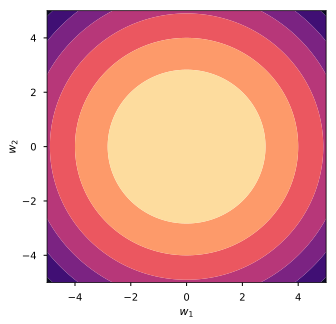

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [14]:
x1 = np.array([ 1.5,  1.])
x2 = np.array([-1.5,  1.])
x3 = np.array([  .5, -1.])

In [15]:
X = np.vstack((x1, x2, x3))
X.shape

(3, 2)

In [16]:
y1 = 1
y2 = 1
y3 = 0

In [17]:
y = np.stack((y1, y2, y3))
y.shape

(3,)

In [18]:
def log_likelihood(w, x, y):
    # equiv. to negative binary cross entropy
    return np.log(expit(np.dot(w.T, x)*(-1)**(1-y)))

In [19]:
llhs = log_likelihood(w_grid.T, X.T, y)
llhs.shape

(300, 300, 3)

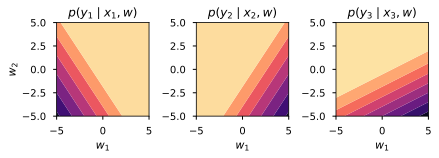

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(w1, w2, llhs[::,::,i], cmap=plt.cm.magma)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    ax.set_title('$p(y_{{{0}}} \mid x_{{{0}}}, w)$'.format(i+1))
    ax.set_xlabel('$w_1$')    
    
    if not i:
        ax.set_ylabel('$w_2$')

plt.show()

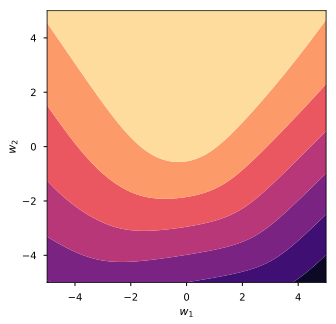

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, np.sum(llhs, axis=2), 
                cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

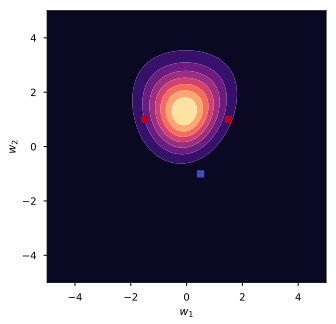

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap='magma')

ax.scatter(*X.T, c=y, cmap='coolwarm', marker=',')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

## Model Definitions

### Density Ratio Estimator (Discriminator) Model

$T_{\psi}(x, z)$

Here we consider

$T_{\psi}(w)$

$T_{\psi} : \mathbb{R}^2 \to \mathbb{R}$

In [23]:
discriminator = Sequential(name='discriminator')
discriminator.add(Dense(10, input_dim=LATENT_DIM, activation='relu'))
discriminator.add(Dense(20, activation='relu'))
discriminator.add(Dense(1, activation=None, name='logit'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(optimizer=Adam(lr=LEARNING_RATE),
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [24]:
ratio_estimator = Model(
    inputs=discriminator.inputs, 
    outputs=discriminator.get_layer(name='logit').output)

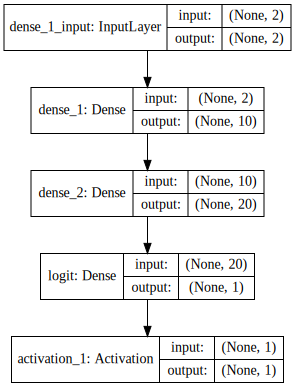

In [25]:
SVG(model_to_dot(discriminator, show_shapes=True)
    .create(prog='dot', format='svg'))

In [26]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

Initial density ratio, prior to any training

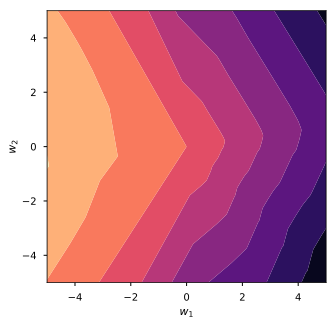

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [28]:
discriminator.evaluate(prior.rvs(size=5), np.zeros(5))

5/5 [==============================] - 0s


[0.53340649604797363, 1.0]

### Approximate Inference Model

$z_{\phi}(x, \epsilon)$

Here we only consider

$z_{\phi}(\epsilon)$

$z_{\phi}: \mathbb{R}^3 \to \mathbb{R}^2$

In [29]:
inference = Sequential()
inference.add(Dense(10, input_dim=NOISE_DIM, activation='relu'))
inference.add(Dense(20, activation='relu'))
inference.add(Dense(LATENT_DIM, activation=None))
inference.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


The variational parameters $\phi$ are the trainable weights of the approximate inference model

In [30]:
phi = inference.trainable_weights
phi

[<tf.Variable 'dense_3/kernel:0' shape=(3, 10) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_4/kernel:0' shape=(10, 20) dtype=float32_ref>,
 <tf.Variable 'dense_4/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(20, 2) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(2,) dtype=float32_ref>]

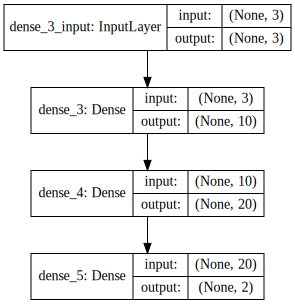

In [31]:
SVG(model_to_dot(inference, show_shapes=True)
    .create(prog='dot', format='svg'))

In [32]:
w_sample_prior = prior.rvs(size=BATCH_SIZE)
w_sample_prior.shape

(200, 2)

In [33]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
w_sample_posterior = inference.predict(eps)
w_sample_posterior.shape

(200, 2)

In [34]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

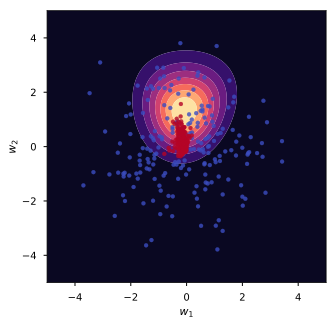

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [36]:
metrics = discriminator.evaluate(inputs, targets)

 32/400 [=>............................] - ETA: 0s

In [37]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

In [38]:
metrics

[0.65425197124481205, 0.58999999999999997]

In [39]:
metrics_dict = dict(zip(discriminator.metrics_names, metrics))

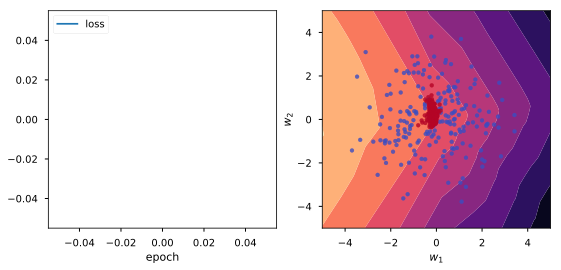

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

metrics_plots = {k:ax1.plot([], label=k)[0] 
                 for k in ['loss']} # discriminator.metrics_names}

ax1.set_xlabel('epoch')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

#### Discriminator pre-training

In [41]:
def train_animate(epoch_num, prog_bar, batch_size=200, steps_per_epoch=15):

    # Single training epoch
    
    for step in tnrange(steps_per_epoch, unit='step', leave=False):

        w_sample_prior = prior.rvs(size=batch_size)

        eps = np.random.randn(batch_size, NOISE_DIM)
        w_sample_posterior = inference.predict(eps)

        inputs = np.vstack((w_sample_prior, w_sample_posterior))
        targets = np.hstack((np.zeros(batch_size), np.ones(batch_size)))

        metrics = discriminator.train_on_batch(inputs, targets)

    # Plot Metrics
        
    metrics_dict = dict(zip(discriminator.metrics_names, metrics))

    for metric in metrics_plots:
        metrics_plots[metric].set_xdata(np.append(metrics_plots[metric].get_xdata(), 
                                                  epoch_num))    
        metrics_plots[metric].set_ydata(np.append(metrics_plots[metric].get_ydata(), 
                                                  metrics_dict[metric]))
        metrics_plots[metric].set_label('{} ({:.2f})' \
                                        .format(metric, 
                                                metrics_dict[metric]))
    
    ax1.set_xlabel('epoch {:2d}'.format(epoch_num))
    ax1.legend(loc='upper left')

    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)

    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)
    
    # Progress Bar Updates
    
    prog_bar.update()
    prog_bar.set_postfix(**metrics_dict)

    return list(metrics_plots.values())

In [42]:
# main training loop is managed by higher-order
# FuncAnimation which makes calls to an `animate` 
# function that encapsulates the logic of single
# training epoch. Has benefit of producing 
# animation but can incur significant overhead
with tqdm_notebook(total=PRETRAIN_EPOCHS, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=PRETRAIN_EPOCHS,
                         interval=200, # 5 fps
                         blit=True)

    anim_html5_video = anim.to_html5_video()

In [43]:
HTML(anim_html5_video)

In [44]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

In [45]:
metrics = discriminator.evaluate(inputs, targets)

 32/400 [=>............................] - ETA: 0s

In [46]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

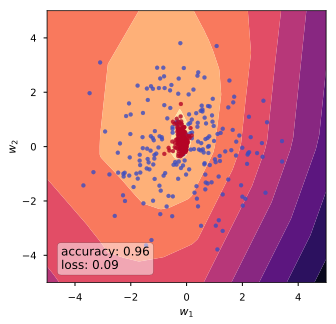

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

metrics_dict = dict(zip(discriminator.metrics_names, metrics))

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax.text(0.05, 0.05, 
        ('accuracy: {binary_accuracy:.2f}\n'        
         'loss: {loss:.2f}').format(**metrics_dict), 
        transform=ax.transAxes, bbox=props)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

### Evidence lower bound

In [48]:
def set_trainable(model, trainable):
    """inorder traversal"""
    model.trainable = trainable

    if isinstance(model, Model): # i.e. has layers
        for layer in model.layers:
            set_trainable(layer, trainable)

In [49]:
y_pred = K.sigmoid(K.dot(
    K.constant(w_grid),
    K.transpose(K.constant(X))))
y_pred

<tf.Tensor 'Sigmoid:0' shape=(300, 300, 3) dtype=float32>

In [50]:
y_true = K.ones((300, 300, 1))*K.constant(y)
y_true

<tf.Tensor 'mul_33:0' shape=(300, 300, 3) dtype=float32>

In [51]:
llhs_keras = - K.binary_crossentropy(
                   y_pred, 
                   y_true, 
                   from_logits=False)

In [52]:
sess = K.get_session()

In [53]:
np.allclose(np.sum(llhs, axis=-1),
            sess.run(K.sum(llhs_keras, axis=-1)))

True

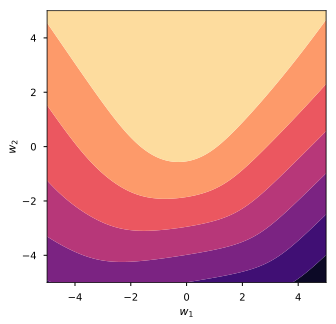

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, sess.run(K.sum(llhs_keras, axis=-1)), 
            cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

# Reweight likelihood term!

In [55]:
def make_elbo(ratio_estimator):
    
    set_trainable(ratio_estimator, False)
    
    def elbo(y_true, w_sample):
        kl_estimate = ratio_estimator(w_sample)
        y_pred = K.dot(w_sample, K.transpose(K.constant(X)))
        log_likelihood = - K.binary_crossentropy(y_pred, y_true, 
                                                 from_logits=True)
        return K.mean(2.*log_likelihood-kl_estimate, axis=-1)

    return elbo

In [56]:
elbo = make_elbo(ratio_estimator)

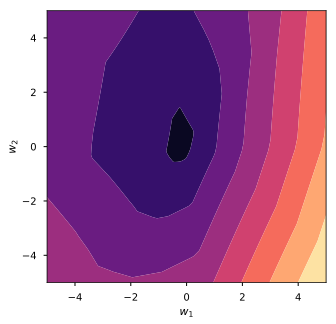

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, sess.run(elbo(y_true, K.constant(w_grid))), 
            cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [58]:
inference_loss = lambda y_true, w_sample: -make_elbo(ratio_estimator)(y_true, w_sample)

In [59]:
inference.compile(loss=inference_loss, 
                  optimizer=Adam(lr=LEARNING_RATE))

In [60]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)

In [61]:
y_true = K.repeat_elements(K.expand_dims(K.constant(y), axis=0), 
                           axis=0, rep=BATCH_SIZE)
y_true

<tf.Tensor 'concat:0' shape=(200, 3) dtype=float32>

In [62]:
sess.run(K.mean(elbo(y_true, inference(K.constant(eps))), axis=-1))

-4.4352226

In [63]:
inference.evaluate(eps, np.tile(y, reps=(BATCH_SIZE, 1)))

 32/200 [===>..........................] - ETA: 0s

4.4352222633361817

### Adversarial Training

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

global_epoch = 0

loss_plot_inference, = ax1.plot([], label='inference')
loss_plot_discrim, = ax1.plot([], label='discriminator')

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [121]:
def train_animate(epoch_num, prog_bar, batch_size=200, 
                  steps_per_epoch=15):

    global global_epoch, loss_plot_inference, loss_plot_discrim
    
    # Single training epoch

    ## Ratio estimator training
        
    set_trainable(discriminator, True)

    for _ in tnrange(3*50, unit='step', desc='discriminator', 
                     leave=False):

        w_sample_prior = prior.rvs(size=BATCH_SIZE)

        eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
        w_sample_posterior = inference.predict(eps)

        inputs = np.vstack((w_sample_prior, w_sample_posterior))
        targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

        metrics_discrim = discriminator.train_on_batch(inputs, targets)

    metrics_dict_discrim = dict(zip(discriminator.metrics_names, 
                                    np.atleast_1d(metrics_discrim)))
    
    ## Inference model training

    print('Before:')
    print(ratio_estimator.get_weights()[0])
    print(inference.get_weights()[0])
    
    set_trainable(ratio_estimator, False)

    y_tiled = np.tile(y, reps=(BATCH_SIZE, 1))

    for _ in tnrange(1, unit='step', desc='inference', leave=False):

        eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
        metrics_inference = inference.train_on_batch(eps, y_tiled)

    print('After:')
    print(ratio_estimator.get_weights()[0])
    print(inference.get_weights()[0])
        
    print('###')
        
    metrics_dict_inference = dict(zip(inference.metrics_names, 
                                      np.atleast_1d(metrics_inference)))

    global_epoch += 1
    
    # Plot Loss
 
    loss_plot_inference.set_xdata(np.append(loss_plot_inference.get_xdata(),
                                            global_epoch))
    loss_plot_inference.set_ydata(np.append(loss_plot_inference.get_ydata(), 
                                            metrics_dict_inference['loss']))

    loss_plot_inference.set_label('inference ({:.2f})' \
                                  .format(metrics_dict_inference['loss']))

    loss_plot_discrim.set_xdata(np.append(loss_plot_discrim.get_xdata(),
                                          global_epoch))
    loss_plot_discrim.set_ydata(np.append(loss_plot_discrim.get_ydata(),
                                          metrics_dict_discrim['loss']))

    loss_plot_discrim.set_label('discriminator ({:.2f})' \
                                  .format(metrics_dict_discrim['loss']))
    
    ax1.set_xlabel('epoch {:2d}'.format(global_epoch))
    ax1.legend(loc='upper left')
    
    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)

    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)
    
    # Progress Bar Updates
    
    prog_bar.update()
    prog_bar.set_postfix(loss_inference=metrics_dict_inference['loss'],
                         loss_discriminator=metrics_dict_discrim['loss'])

    return loss_plot_inference, loss_plot_discrim

In [122]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

Before:
[[ 0.4   0.69 -0.56 -0.45  0.03  0.23 -0.67 -0.19  0.21  0.71]
 [-0.33 -0.29  0.22  0.54 -0.58 -1.03 -0.29 -0.75  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.02  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.21 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]


After:
[[ 0.4   0.69 -0.56 -0.45  0.03  0.23 -0.67 -0.19  0.21  0.71]
 [-0.33 -0.29  0.22  0.54 -0.58 -1.03 -0.29 -0.75  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.02  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.21 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]
###


Before:
[[ 0.43  0.7  -0.54 -0.43  0.04  0.23 -0.68 -0.18  0.25  0.71]
 [-0.32 -0.28  0.18  0.53 -0.56 -1.02 -0.29 -0.75  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.02  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.21 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]


After:
[[ 0.43  0.7  -0.54 -0.43  0.04  0.23 -0.68 -0.18  0.25  0.71]
 [-0.32 -0.28  0.18  0.53 -0.56 -1.02 -0.29 -0.75  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]
###


Before:
[[ 0.43  0.7  -0.52 -0.42  0.05  0.23 -0.68 -0.18  0.24  0.7 ]
 [-0.34 -0.28  0.2   0.55 -0.54 -1.03 -0.29 -0.74  0.79 -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]


After:
[[ 0.43  0.7  -0.52 -0.42  0.05  0.23 -0.68 -0.18  0.24  0.7 ]
 [-0.34 -0.28  0.2   0.55 -0.54 -1.03 -0.29 -0.74  0.79 -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]
###


Before:
[[ 0.42  0.71 -0.54 -0.41  0.07  0.23 -0.67 -0.13  0.25  0.71]
 [-0.32 -0.28  0.18  0.55 -0.58 -1.02 -0.3  -0.79  0.81 -0.23]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]


After:
[[ 0.42  0.71 -0.54 -0.41  0.07  0.23 -0.67 -0.13  0.25  0.71]
 [-0.32 -0.28  0.18  0.55 -0.58 -1.02 -0.3  -0.79  0.81 -0.23]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]
###


Before:
[[ 0.39  0.7  -0.52 -0.4   0.06  0.23 -0.67 -0.15  0.27  0.7 ]
 [-0.36 -0.28  0.2   0.52 -0.56 -1.03 -0.3  -0.74  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.21 -0.67 -0.61  0.53]]


After:
[[ 0.39  0.7  -0.52 -0.4   0.06  0.23 -0.67 -0.15  0.27  0.7 ]
 [-0.36 -0.28  0.2   0.52 -0.56 -1.03 -0.3  -0.74  0.8  -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]
###


Before:
[[ 0.37  0.67 -0.54 -0.44  0.05  0.24 -0.68 -0.15  0.27  0.7 ]
 [-0.39 -0.32  0.2   0.52 -0.56 -1.04 -0.3  -0.73  0.81 -0.21]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.78  0.12  0.65 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.12 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]


After:
[[ 0.37  0.67 -0.54 -0.44  0.05  0.24 -0.68 -0.15  0.27  0.7 ]
 [-0.39 -0.32  0.2   0.52 -0.56 -1.04 -0.3  -0.73  0.81 -0.21]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.77  0.12  0.65 -0.31]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.13 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]
###


Before:
[[ 0.39  0.68 -0.51 -0.42  0.05  0.23 -0.68 -0.17  0.27  0.71]
 [-0.37 -0.28  0.19  0.5  -0.54 -1.03 -0.3  -0.74  0.83 -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.77  0.12  0.65 -0.31]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.13 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]


After:
[[ 0.39  0.68 -0.51 -0.42  0.05  0.23 -0.68 -0.17  0.27  0.71]
 [-0.37 -0.28  0.19  0.5  -0.54 -1.03 -0.3  -0.74  0.83 -0.22]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.77  0.12  0.65 -0.31]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.13 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]
###


Before:
[[ 0.38  0.7  -0.56 -0.44  0.03  0.21 -0.67 -0.15  0.23  0.71]
 [-0.36 -0.27  0.2   0.51 -0.55 -1.01 -0.29 -0.74  0.81 -0.2 ]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.77  0.12  0.65 -0.31]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.13 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]


After:
[[ 0.38  0.7  -0.56 -0.44  0.03  0.21 -0.67 -0.15  0.23  0.71]
 [-0.36 -0.27  0.2   0.51 -0.55 -1.01 -0.29 -0.74  0.81 -0.2 ]]
[[-0.33 -0.64  0.37 -0.19 -0.02  0.01  0.77  0.12  0.66 -0.3 ]
 [ 0.41 -0.5   0.5   0.17 -0.22 -0.41  0.61 -0.13 -0.13 -0.68]
 [ 0.71 -0.47 -0.69 -0.42 -0.21  0.41  0.22 -0.67 -0.61  0.53]]
###



KeyboardInterrupt: 

In [67]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

In [68]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

KeyboardInterrupt: 

In [ ]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

### Evaluating the model

In [ ]:
w_sample_prior = prior.rvs(size=128)
eps = np.random.randn(256, NOISE_DIM)
w_sample_posterior = inference.predict(eps)
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(128), np.ones(256)))

In [ ]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax1.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax1.set_xlabel('$w_1$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

ax2.contourf(w1, w2, np.sum(llhs, axis=2), 
             cmap=plt.cm.magma)
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [ ]:
eps = np.random.randn(5000, NOISE_DIM)
w_sample_posterior = inference.predict(eps)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax1.scatter(*inference.predict(eps[::10]).T, 
            s=4.**2, alpha=.6, cmap='coolwarm_r')

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

sns.kdeplot(*inference.predict(eps).T,
            cmap='magma', ax=ax2)

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [107]:
output = expit(np.random.randn(256))
target = np.hstack((np.zeros(128), np.ones(128)))

In [108]:
2*K.mean(K.binary_crossentropy(output=K.constant(output), 
                      target=K.constant(target))).eval(session=sess)

1.7183432579040527

In [109]:
np.mean(-np.log(output[128:])-np.log(1-output[:128]))

1.7183431791525026

In [94]:
(-np.log(output[:128])-np.log(1-output[128:])).shape

(128,)

In [74]:
p1[:128][0]

0.343090641899925

In [73]:
p1[128:][0]

0.50225667608674573

In [113]:
ratio_estimator.get_weights()[0]

array([[ 0.34,  0.75, -0.56, -0.46,  0.04,  0.25, -0.64, -0.32,  0.05,  0.67],
       [-0.38, -0.27,  0.19,  0.55, -0.63, -0.96, -0.27, -0.75,  0.82, -0.13]], dtype=float32)